# BASE DE DADOS

Descrição dos atributos:

* DATA: Data da venda
* TOTAL: Total em R$ das vendas

O dataset apresenta dados reais de uma empresa de comércio do varejo onde o objetivo é prever o valor das vendas do futuro utilizado o modelo SARIMA.


In [ ]:
#!pip install pmdarima


In [ ]:
# Bibliotecas

import pandas as pd
import numpy as np
import seaborn as sns
import pmdarima as pm
import matplotlib.pyplot as plt
%matplotlib inline

import plotly.graph_objects as go
from sklearn.model_selection import train_test_split
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
from statsmodels.tsa.stattools import adfuller
from pandas.plotting import autocorrelation_plot
from pmdarima.arima import auto_arima
import statsmodels.api as sm

import warnings
warnings.filterwarnings("ignore")

# UPLOAD DATASET


In [ ]:
data = '/content/dataset_vendas.xlsx'
df = pd.read_excel(data)

# VISÃO GERAL DOS DADOS

In [ ]:
df.shape

(1728, 2)

In [ ]:
df.head()

,DATA,TOTAL
0,2018-01-02,7825.46
1,2018-01-03,8867.03
2,2018-01-04,7223.18
3,2018-01-05,11430.90
4,2018-01-06,17018.11


In [ ]:
df.tail()

,DATA,TOTAL
1723,2023-09-26,16728.54
1724,2023-09-27,17949.51
1725,2023-09-28,17325.77
1726,2023-09-29,14714.63
1727,2023-09-30,19446.48


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1728 entries, 0 to 1727
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   DATA    1728 non-null   datetime64[ns]
 1   TOTAL   1728 non-null   float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 27.1 KB


In [ ]:
df['TOTAL'].describe()

count     1728.000000
mean     16669.623767
std       7817.420807
min     -14363.910000
25%      11726.525000
50%      15351.045000
75%      19865.237500
max      80741.780000
Name: TOTAL, dtype: float64

# PREPARAÇÃO DOS DADOS

In [ ]:
# Agrupando os dados por mês
df2 = df.resample('M', on='DATA').sum()

In [ ]:
df2.head()

,TOTAL
DATA,
2018-01-31,297859.38
2018-02-28,242449.81
2018-03-31,294373.22
2018-04-30,353152.11
2018-05-31,335047.37


In [ ]:
df2.tail()

,TOTAL
DATA,
2023-05-31,736903.91
2023-06-30,590467.14
2023-07-31,658885.96
2023-08-31,545835.71
2023-09-30,505851.57


# ANÁLISE EXPLORATÓRIA

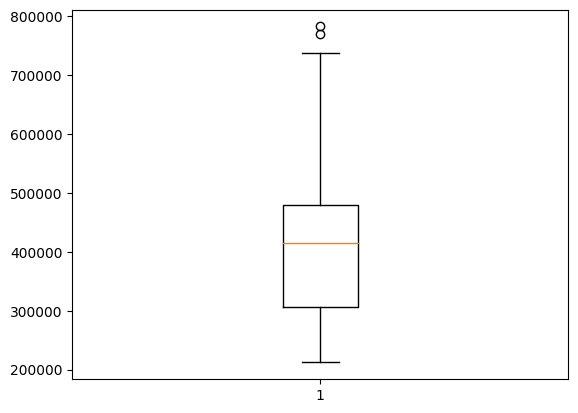

In [ ]:
# Boxplot (Identificar Outliers)
plt.boxplot(df2['TOTAL'])
plt.show()

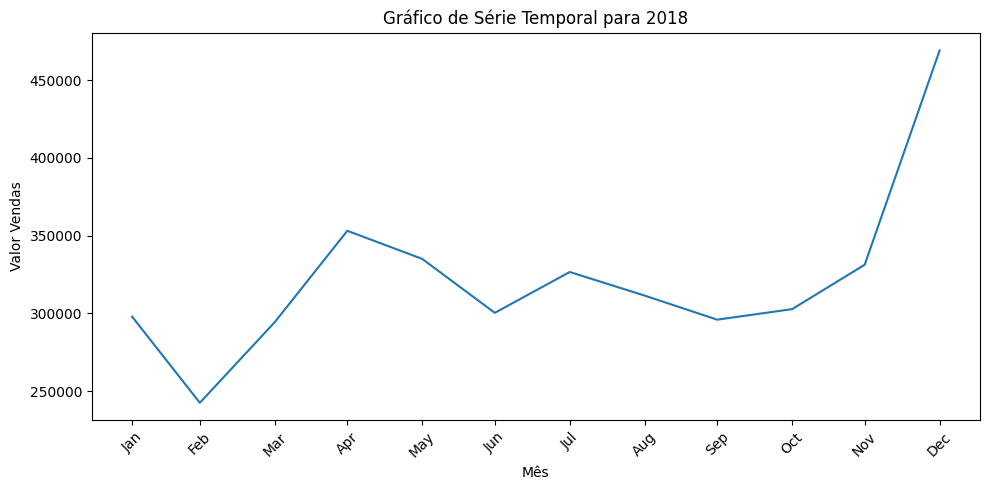

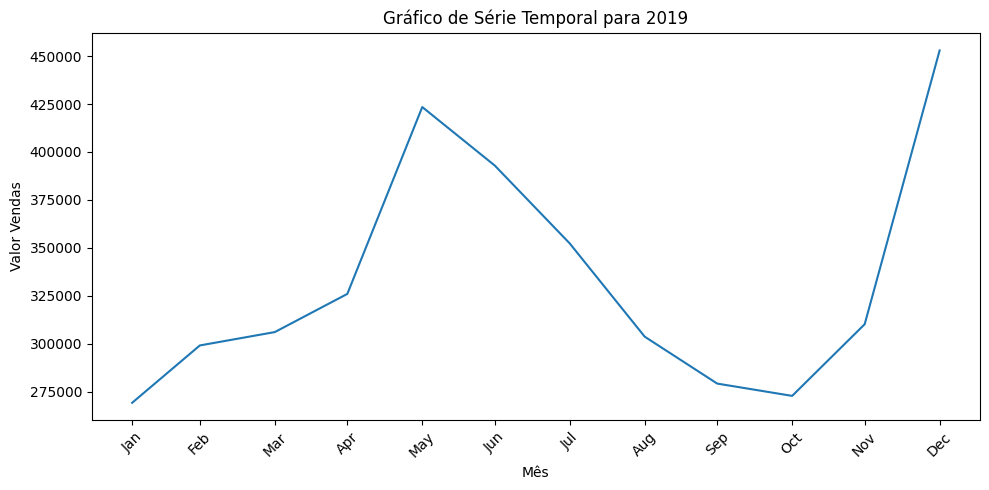

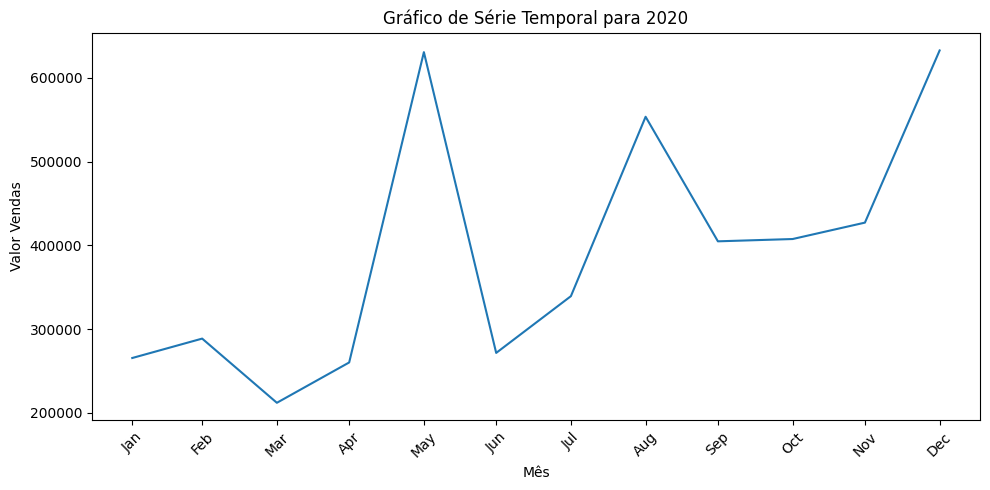

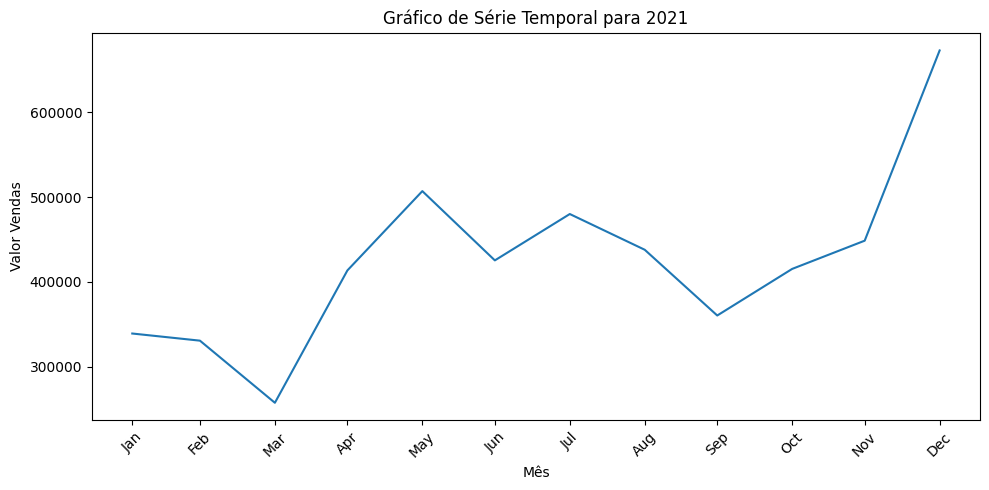

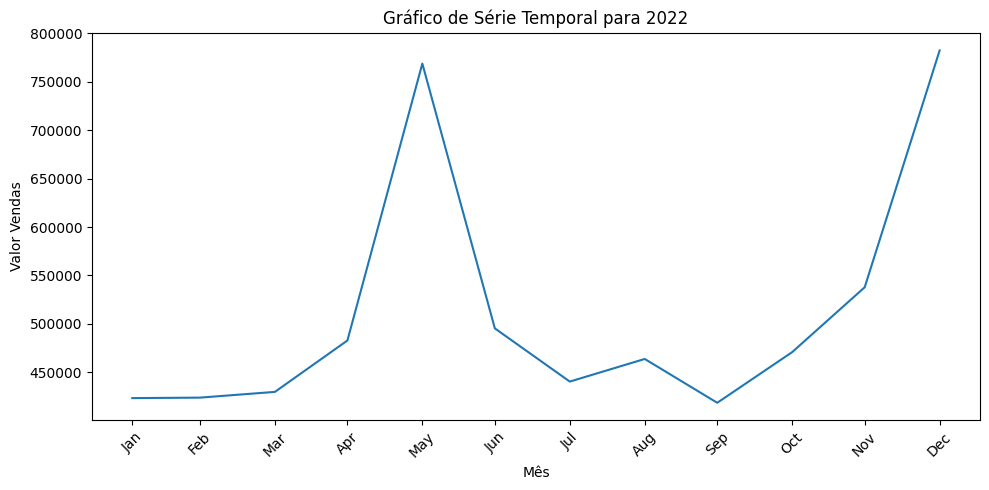

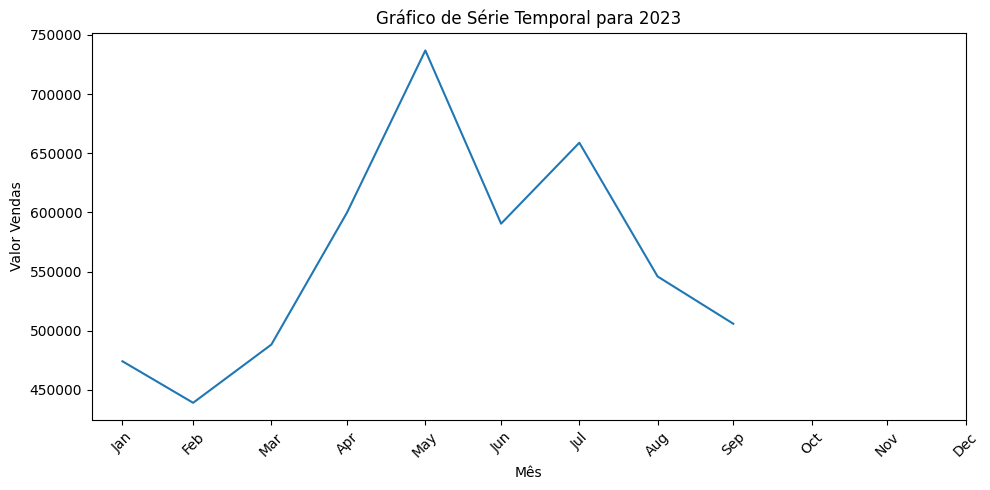

In [ ]:
# Gráfico de linhas
anos = df2.index.year.unique()

for ano in anos:
    df_ano = df2[df2.index.year == ano]

    plt.figure(figsize=(10, 5))
    plt.plot(df_ano.index, df_ano['TOTAL'])
    plt.title(f'Gráfico de Série Temporal para {ano}')
    plt.xlabel('Mês')
    plt.ylabel('Valor Vendas')
    plt.xticks(pd.date_range(start=f"{ano}-01-01", end=f"{ano}-12-31", freq='M'),
               [d.strftime('%b') for d in pd.date_range(start=f"{ano}-01-01", end=f"{ano}-12-31", freq='M')],
               rotation=45)
    plt.tight_layout()
    plt.show()

## TESTE DE ESTACIONARIDADE

* Estacionariedade refere-se a uma série temporal cujas propriedades estatísticas (como média, variância) não mudam ao longo do tempo. Uma série estacionária não tem tendência ou sazonalidade.

* Não-estacionariedade refere-se a uma série temporal que possui tendências ou sazonalidades, o que significa que suas propriedades estatísticas mudam ao longo do tempo.

In [ ]:
# Teste de Dickey-Fuller
def adfuller_test(sales):
  result = adfuller(sales)
  labels = ['ADF Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used']
  for value,label in zip(result,labels):
    print(label+': '+str(value))
  if result[1] <= 0.05: # p-value
    print("\nTipo de série: Estacionária")
  else:
    print("\nTipo de série: Não-estacionária")

In [ ]:
adfuller_test(df2['TOTAL'])

ADF Test Statistic: 0.9842725020130892
p-value: 0.9940972019785612
#Lags Used: 11
Number of Observations Used: 57

Tipo de série: Não-estacionária


## DECOMPOSIÇÃO

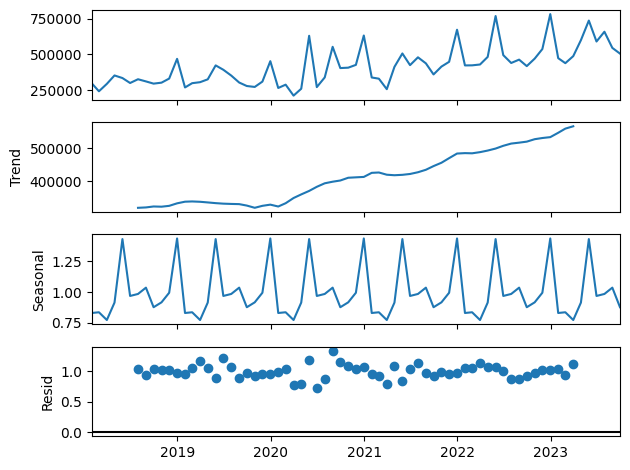

In [ ]:
# Decomposição de sazonalidade
result = seasonal_decompose(df2, model='multiplicative') # parâmetro 'model' ajustado para "multiplicative" pois apresenta uma sazonalidade constante ao longo do tempo

result.plot()
plt.show()

## AUTOCORRELAÇÃO

A autocorrelação mede a relação entre uma observação e suas observações anteriores (ou lags) em uma série temporal. Analisar a autocorrelação é fundamental ao modelar séries temporais para entender a dependência entre os valores ao longo do tempo.

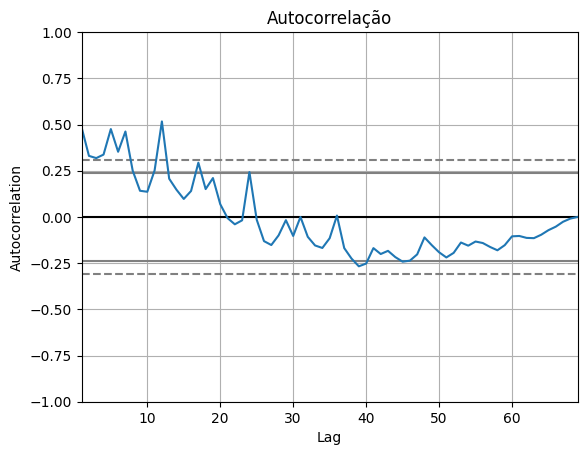

In [ ]:
# Autocorrelação
autocorrelation_plot(df2['TOTAL'])
plt.title(f'Autocorrelação')
plt.show()

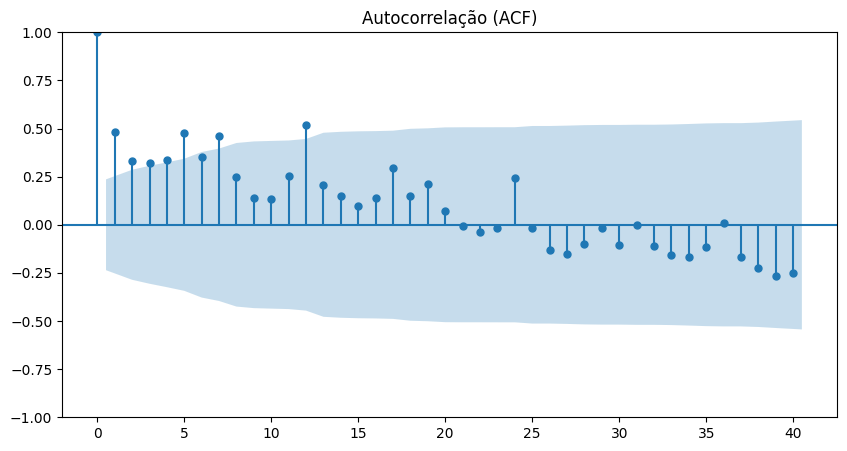

In [ ]:
# Autocorrelação (ACF) - Ajuda na definição dos parâmetros MA (q,Q)
fig, ax = plt.subplots(figsize=(10, 5))
sm.graphics.tsa.plot_acf(df2['TOTAL'], lags=40, ax=ax)
ax.set_title(f'Autocorrelação (ACF)')
plt.show()

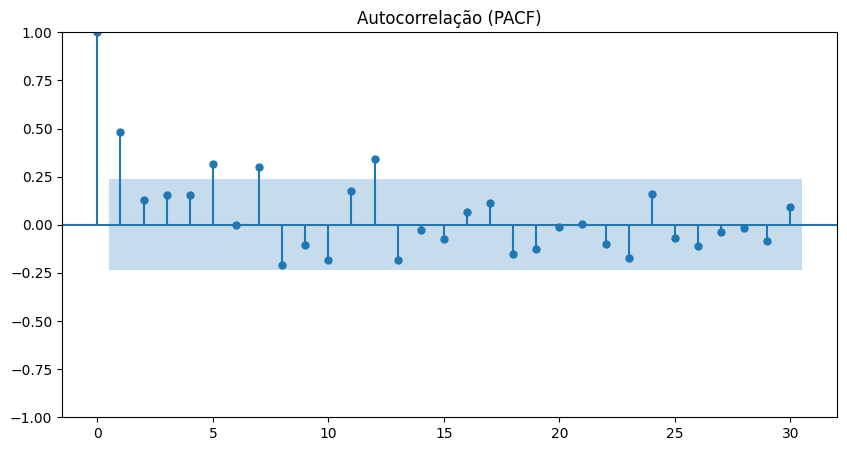

In [ ]:
# Autocorrelação parcial (PACF) - Ajuda na definição dos parâmetros AR (p,P)
fig, ax = plt.subplots(figsize=(10, 5))
sm.graphics.tsa.plot_pacf(df2['TOTAL'], lags=30, ax=ax)
ax.set_title(f'Autocorrelação (PACF)')
plt.show()

# TRATAMENTO DE OUTLIERS

Iremos substituir todos os valores abaixo do limite inferior pelo próprio limite inferior, e todos os valores acima do limite superior pelo limite superior. Esse método é conhecido como "winsorizing" e ajuda a minimizar o impacto de outliers extremos sem excluir os pontos de dados.





In [ ]:
Q1 = df2['TOTAL'].quantile(0.25)
Q3 = df2['TOTAL'].quantile(0.75)
IQR = Q3 - Q1

# Definir os limites para outliers
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Tratar outliers substituindo-os pelos limites
df2['TOTAL'] = np.where(df2['TOTAL']< lower_bound, lower_bound, df2['TOTAL'])
df2['TOTAL'] = np.where(df2['TOTAL'] > upper_bound, upper_bound, df2['TOTAL'])

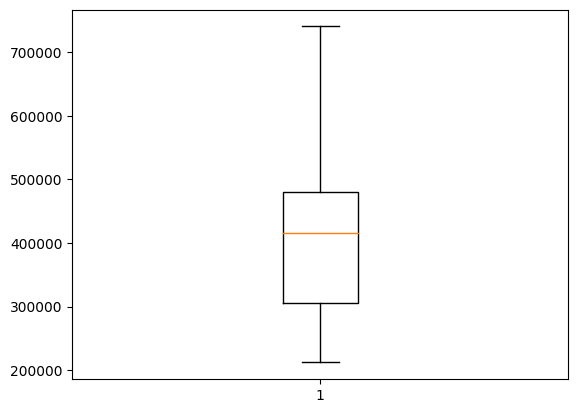

In [ ]:
plt.boxplot(df2['TOTAL'])
plt.show()

# SARIMA

O modelo SARIMA (Seasonal Autoregressive Integrated Moving Average) é uma técnica para previsão e análise de séries temporais, considerando tendências, ciclos sazonais e padrões autocorrelacionados. Ele combina componentes autoregressivos, integrados e de médias móveis, adaptando-se a diferentes padrões e flutuações nos dados. É utilizado para realizar previsões com base em observações passadas.

In [ ]:
# Divide o modelo em treino e teste (Pega quatro anos completos para o treino e o restante para teste)
train = df2[:60]
test = df2[60:]

print(f"Train dates : {train.index.min()} --- {train.index.max()}  (n={len(train)})")
print(f"Test dates  : {test.index.min()} --- {test.index.max()}  (n={len(test)})")

Train dates : 2018-01-31 00:00:00 --- 2022-12-31 00:00:00  (n=60)
Test dates  : 2023-01-31 00:00:00 --- 2023-09-30 00:00:00  (n=9)


In [ ]:
# Cria o modelo SARIMA utilizando o auto_arima (ajusta automaticamente os hiperparâmetros)
model = pm.auto_arima(train,
                      start_p=1, d=None, start_q=1,
                      test='adf',
                      max_p=5, max_q=5,
                      m=12, # considerar a sazonalidade a cada 12 observações (ou meses)
                      start_P=1, D=None, start_Q=1,
                      stationarity=False,
                      seasonal=True,
                      #seasonal_test='ch',
                      trace=True,
                      error_action='ignore',
                      suppress_warnings=True,
                      stepwise=True,
                      information_criterion='aic')

# Previsão para os dados de treino
predictions_train = model.predict_in_sample()

# Previsão para os primeiros 9 meses de 2023
predictions_test = model.predict(n_periods=len(test))

# Retreinando o modelo com todos os dados até Setembro de 2023 - Base real
model_full = model.update(df2)

# Previsão para Outubro, Novembro e Dezembro de 2023
future_predictions = model_full.predict(n_periods=3)

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(1,1,1)[12]             : AIC=1216.154, Time=0.55 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=1235.369, Time=0.05 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=1218.155, Time=0.21 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=1212.878, Time=0.34 sec
 ARIMA(0,1,1)(0,1,0)[12]             : AIC=1219.717, Time=0.10 sec
 ARIMA(0,1,1)(1,1,1)[12]             : AIC=1214.323, Time=0.37 sec
 ARIMA(0,1,1)(0,1,2)[12]             : AIC=1214.448, Time=0.52 sec
 ARIMA(0,1,1)(1,1,0)[12]             : AIC=1212.384, Time=0.20 sec
 ARIMA(0,1,1)(2,1,0)[12]             : AIC=1214.337, Time=0.48 sec
 ARIMA(0,1,1)(2,1,1)[12]             : AIC=1216.274, Time=1.61 sec
 ARIMA(0,1,0)(1,1,0)[12]             : AIC=1223.807, Time=0.08 sec
 ARIMA(1,1,1)(1,1,0)[12]             : AIC=1214.233, Time=0.17 sec
 ARIMA(0,1,2)(1,1,0)[12]             : AIC=1215.188, Time=0.12 sec
 ARIMA(1,1,2)(1,1,0)[12]             : AIC=1215.034, Time=0.24 sec
 ARIMA(0,1,1)(1,1,0

# AVALIAÇÃO DO MODELO

## SUMÁRIO

In [ ]:
print(model.summary())

                                      SARIMAX Results                                      
Dep. Variable:                                   y   No. Observations:                  129
Model:             SARIMAX(0, 1, 1)x(1, 1, [], 12)   Log Likelihood               -1485.314
Date:                             Tue, 14 Nov 2023   AIC                           2976.628
Time:                                     22:56:57   BIC                           2984.889
Sample:                                          0   HQIC                          2979.982
                                             - 129                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.5772      0.091     -6.361      0.000      -0.755      -0.399
ar.S.L12      -0.5003      

Os p-values (P>|z|) para os coeficientes são menores do que 0,05, indicando que os coeficientes são estatisticamente significativos.

## GRÁFICO

In [ ]:
# Criar um gráfico
fig = go.Figure()

# Adicionar linhas ao gráfico
fig.add_trace(go.Scatter(x=train.index, y=train['TOTAL'], mode='lines+markers', name='Dados Reais de Treino', line=dict(color='blue')))
fig.add_trace(go.Scatter(x=test.index, y=test['TOTAL'], mode='lines+markers', name='Dados Reais de Teste', line=dict(color='green')))
fig.add_trace(go.Scatter(x=test.index, y=predictions_test, mode='lines+markers', name='Previsões para Teste', line=dict(color='red', dash='dash')))
fig.add_trace(go.Scatter(x=pd.date_range(start='2023-10', periods=3, freq='M'), y=future_predictions, mode='lines+markers', name='Previsões Futuras', line=dict(color='orange', dash='dash')))

# Adicionar título e legenda
fig.update_layout(
    title={
        'text': 'Previsões SARIMA',
        'x': 0.5,
        'xanchor': 'center'
    },
    xaxis_title='PERÍODO',
    yaxis_title='TOTAL',
    showlegend=True
)

# Ajustar o tamanho do gráfico
fig.update_layout(autosize=False, width=1500, height=700)

# Mostrar o gráfico
fig.show()


In [ ]:
# Exibe as previsões em um dataframe
dates = pd.date_range(start='2023-10', periods=3, freq='M')

future_df = pd.DataFrame(future_predictions, index=dates, columns=["previsao"])
future_df['previsao'] = future_df['previsao'].apply(lambda x: 'R$ {:,.2f}'.format(x).replace(',', 'x').replace('.', ',').replace('x', '.'))
future_df

,previsao
2023-10-31,"R$ 567.317,24"
2023-11-30,"R$ 617.439,73"
2023-12-31,"R$ 831.131,99"


## MÉDIA DOS ERROS

In [ ]:
# Calcula as métricas de desempenho para os dados de treino
print('Métricas de desempenho para os dados de treino:')
rmse_train = np.sqrt(mean_squared_error(train, predictions_train))
print('RMSE:', rmse_train)
mae_train = mean_absolute_error(train, predictions_train)
print('MAE:', mae_train)
mape_train = mean_absolute_percentage_error(train, predictions_train)
print('MAPE:', mape_train)

# Calcula as métricas de desempenho para os dados de teste
print('\nMétricas de desempenho para os dados de teste:')
rmse_test = np.sqrt(mean_squared_error(test, predictions_test))
print('RMSE:', rmse_test)
mae_test = mean_absolute_error(test, predictions_test)
print('MAE:', mae_test)
mape_test = mean_absolute_percentage_error(test, predictions_test)
print('MAPE:', mape_test)

Métricas de desempenho para os dados de treino:
RMSE: 101116.20777574732
MAE: 71888.79652217762
MAPE: 0.20262970311709533

Métricas de desempenho para os dados de teste:
RMSE: 55414.731049742615
MAE: 42935.87529965303
MAPE: 0.07481941885917504


> Analisando as médias dos erros:


* RMSE: A raiz do erro quadrático médio é uma métrica que expressa a média das diferenças ao quadrado entre os valores reais e previstos. Valores menores indicam um melhor ajuste do modelo. Nota-se uma melhoria significativa do RMSE quando se passa dos dados de treino para os dados de teste, o que é um bom sinal.

* MAE: O erro absoluto médio representa a média das diferenças absolutas entre os valores previstos e reais. Assim como o RMSE, o MAE é menor nos dados de teste em comparação com os dados de treino, indicando uma melhora no desempenho do modelo.

* MAPE: O erro percentual absoluto médio mostra a média das diferenças percentuais absolutas entre os valores previstos e reais. Uma redução substancial de 20.26% para 7.48% é observada, o que sugere que o modelo é consideravelmente mais preciso ao fazer previsões nos dados de teste.

# CONCLUSÃO

A análise exploratória revela padrões que se repetem em intervalos regulares. O gráfico de decomposição exibe uma tendência ascendente, indicando um crescimento nas vendas ao longo dos anos, e também destaca picos sazonais.

A avaliação do modelo pelo gráfico "Previsões SARIMA" mostra que as projeções para a base teste seguem de perto os dados reais, sugerindo um bom ajuste do modelo. As previsões para os últimos meses também parecem promissoras, corroborando com a tendência de crescimento anual e o aumento sazonal nas vendas observados nos anos anteriores.

Vale ressaltar que estamos lidando com um conjunto de dados real e conhecido, especialmente no que se refere à tendência de crescimento das vendas e à sazonalidade. Apesar de algumas preocupações, especialmente com os valores mais elevados de RMSE e MAE nos dados de treino (que podem ser justificados por contextos ausentes na base, como a pandemia e investimentos realizados na loja), a melhora nas métricas ao passar dos dados de treino para os de teste é um indicativo positivo. No entanto, é essencial avaliar esses resultados no contexto específico das necessidades e objetivos de negócios para determinar a adequação e confiabilidade do modelo para previsões de vendas futuras. Como procedimento de validação, seria prudente aguardar os resultados de vendas dos meses subsequentes para confrontá-los com as previsões do modelo, a fim de avaliar sua precisão e confiabilidade.